In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

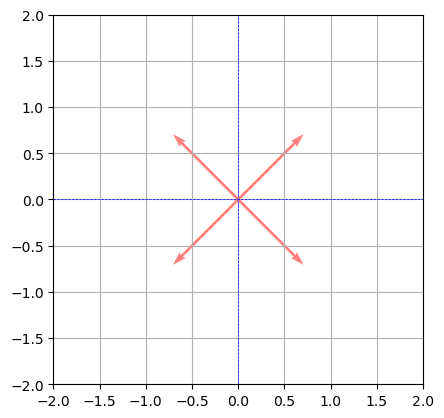

In [136]:
# define directions (angles) to test
# lets start with 4 directions

vertices = [ # get these by dir cosines from angle array
    np.array([np.sqrt(2)/2, np.sqrt(2)/2]),
    np.array([-np.sqrt(2)/2, np.sqrt(2)/2]),
    np.array([-np.sqrt(2)/2, -np.sqrt(2)/2]),
    np.array([np.sqrt(2)/2, -np.sqrt(2)/2])
]

def plot_experimental_design(vertices):
    # plot vertices in cartesian coordinates with arrows

    fig, ax = plt.subplots()

    for v in vertices:
        ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)

    ax.set_aspect('equal')
    ax.grid(True)
    ax.axhline(0, color='blue', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='blue', linestyle='--', linewidth=0.5)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

plot_experimental_design(vertices)

tested motion directions in red

In [137]:
# def direction_cosines(v: np.ndarray) -> np.ndarray:
#     basis = np.array([[1,0], [0,1]])
#     normalize = lambda v: v / np.linalg.norm(v)

#     cos_x = normalize(v) @ basis[0]
#     cos_y = normalize(v) @ basis[1]
    
#     return np.array([cos_x, cos_y])

In [138]:
# check if motion direction vectors are normalized
for i in range(len(vertices)):
    assert np.sqrt(vertices[i][0]**2 + vertices[i][1]**2) == 1

In [139]:
np.random.lognormal(mean=2.5, sigma=0.2, size=2)

array([15.21274333, 10.08986812])

In [140]:
def discharge_rate(phi_preferred, phi_motion):
    # b, k = np.random.normal(loc=10, scale=4, size=2)
    b, k = np.random.lognormal(mean=2.5, sigma=0.2, size=2)
    return b + k * np.cos(phi_preferred - phi_motion)


def get_regression_coefficients(vertices, discharge_rates):
    Y = discharge_rates
    X = vertices

    # assert np.linalg.matrix_rank(vertices) > 1

    X_design = sm.add_constant(X, has_constant='add')
    model = sm.OLS(Y, X_design).fit()
    # model.summary()

    return model.params


def compute_cardinal_direction_vector(params): # C vector
    b, b_x, b_y = params
    k = np.sqrt(b_x**2 + b_y**2)
    
    return np.array([b_x/k, b_y/k])


def compute_vectorial_contribution(params, discharge_rate): # N vector
    
    # extract coefficients (bs)
    b, b_x, b_y = params

    C = compute_cardinal_direction_vector(params)
    
    # vector weight
    w_M = discharge_rate - b
    
    # weighted direction vector
    N_M = w_M * C
    
    return N_M

a few cells

In [162]:
class Cell: #dataclass?
    def __init__(self, phi_preferred, tested_angles):
        self.preferred_angle = phi_preferred
        self.discharge_rates = [discharge_rate(self.preferred_angle, phi) for phi in tested_angles]
    
    # def initialize_discharge_rates(self, tested_angles):
    #     self.discarge_rates = [discharge_rate(self.preferred_angle, phi) for phi in tested_angles]
    def __repr__(self):
        return f'Cell(preferred_angle={self.preferred_angle}'

In [191]:
tested_angles = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4] # part of design
preferred_angle = tested_angles[2]

In [164]:
cells = [Cell(tested_angles[2], tested_angles) for i in range(10)]

[Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414,
 Cell(preferred_angle=3.9269908169872414]

In [202]:
tested_angle = 0

[74.75319234 76.57002391]


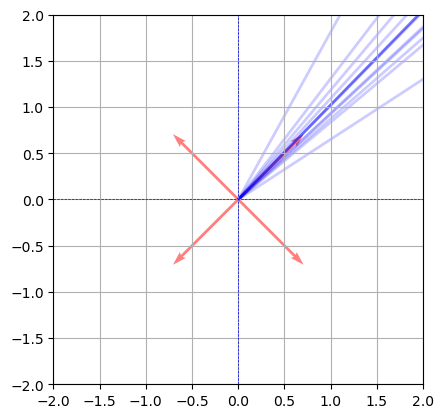

In [203]:
Ns = np.empty((len(cells), 2))

plot_experimental_design(vertices)


for i, c in enumerate(cells):
    params = get_regression_coefficients(vertices, c.discharge_rates)
    C = compute_cardinal_direction_vector(params)
    N = compute_vectorial_contribution(params, c.discharge_rates[tested_angle])
    plt.quiver(0, 0, N[0], N[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.2)
    Ns[i, :] = N

P = np.sum(Ns, axis=0)

print(P)
plt.quiver(0, 0, P[0], P[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)

sim 1

In [141]:
tested_angles = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4] # part of design
preferred_angle = tested_angles[2]

In [142]:
discharge_rates = [discharge_rate(preferred_angle, phi) for phi in tested_angles]
# test if cardinal highest and opposite lowest
discharge_rates

[1.973339510786948, 10.928014769690705, 27.528216819310053, 15.266743956572027]

In [143]:
params = get_regression_coefficients(vertices, discharge_rates)
print(params)

[ 13.92407876  -7.5010411  -10.56898593]


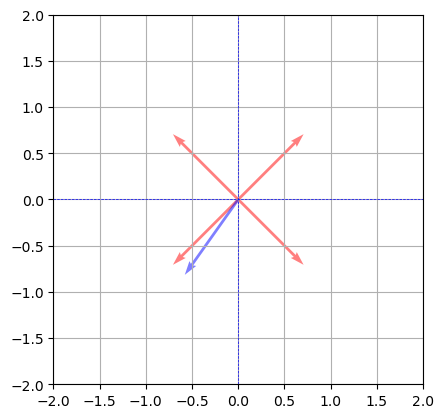

In [144]:
C = compute_cardinal_direction_vector(params)

plot_experimental_design(vertices)
plt.quiver(0, 0, C[0], C[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)

[ -7.87368258 -11.09403871]


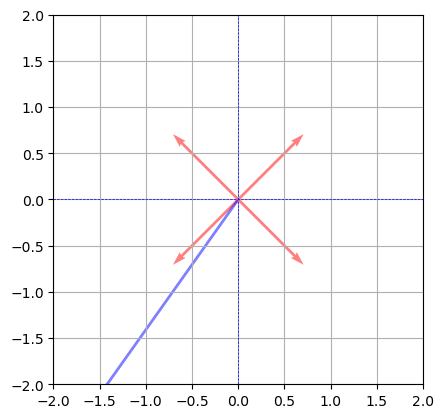

In [148]:
plot_experimental_design(vertices)
N = compute_vectorial_contribution(params, discharge_rates[2])
print(N)
plt.quiver(0, 0, N[0], N[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)